<a href="https://colab.research.google.com/github/SihaoCheng/scattering_transform/blob/master/scattering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

%matplotlib inline
# import packages
import numpy as np
import matplotlib.pyplot as plt
import torch

import sys
colab_dir = '/content/drive/MyDrive/Colab Notebooks/'
sys.path.append(colab_dir)
import scattering
# import importlib
# importlib.reload(scattering)

In [ ]:
import scattering
import importlib
importlib.reload(scattering)

<module 'scattering' from '/content/drive/MyDrive/Colab Notebooks/scattering/__init__.py'>

# Analysis Example

## one field

number of moments (without low-pass and harr):  44096
this chunk 0  size is  832  among  832


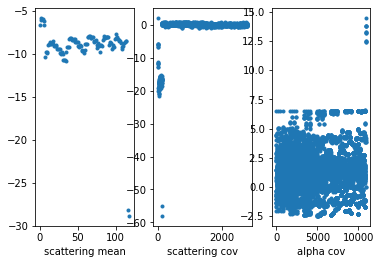

In [ ]:
# define calculators
M = N = 256
J = 7
L = 4
ac_calc = scattering.PhaseHarmonics2d(M, N, J, L, device='gpu')
st_calc = scattering.Scattering2d(M, N, J, L, device='gpu', wavelets='shannon')

k_range = np.logspace(0,np.log10(M/2*1.4), J-1)
bi_calc = scattering.Bispectrum_Calculator(k_range, M, N, device='gpu')

# load image
image_input = np.load(colab_dir + 'H51_9.npy')[None,:M,:N]

# calculate estimators
s_mean = st_calc.scattering_coef(image_input, flatten=True)['for_synthesis_iso']
s_cov  = st_calc.scattering_cov (image_input, flatten=True)['for_synthesis_iso']
alpha_cov = ac_calc.forward(image_input)
bi = bi_calc.forward(image_input)

# plot
# print(s_mean.shape, s_cov.shape, alpha_cov.shape)
plt.subplot(131)
plt.plot(s_mean[0].cpu(),'.')
plt.xlabel('scattering mean')
plt.subplot(132)
plt.plot(s_cov[0].cpu(),'.')
plt.xlabel('scattering cov')
plt.subplot(133)
plt.plot(alpha_cov[0].cpu(),'.')
plt.xlabel('alpha cov')
plt.show()

## two fields

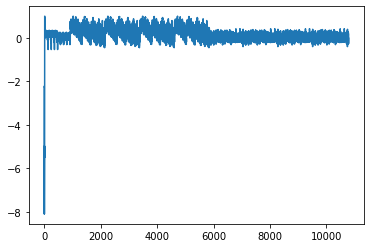

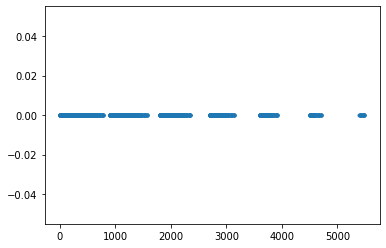

In [ ]:
# define calculator
M = N = 256
J = 7
L = 4
st_calc = scattering.Scattering2d(M, N, J, L, device='gpu')

# load image (image1,2 should have a shape of [N_image, N_xpix, N_ypix])
image1 = np.load(colab_dir + 'turbulence/iso/iso_u_t1z1.npy')[None,:M,:N,1,0]
image2 = np.load(colab_dir + 'turbulence/iso/iso_u_t1z1.npy')[None,:M,:N,1,0]

# calculate scattering correlations, including auto and cross terms for the 2 fields
s_cov_2fields = st_calc.scattering_cov_2fields(image1, image2, flatten=True)
plt.plot(s_cov_2fields['for_synthesis_iso'][0].cpu())
plt.show()

# comparison between auto and cross terms. Because the field1 and field2 are identical in my case, I expect
# that the cross terms are also identical to the auto terms.
s_cov_2fields = st_calc.scattering_cov_2fields(image1, image2, flatten=False)
plt.plot(
    (s_cov_2fields['Corr11_iso'][0,3] - s_cov_2fields['Corr11_iso'][0,3]*1).cpu().real.flatten(), '.-'
)
plt.show()

# Synthesis Example

## one field, image target

In [ ]:
# image_target = np.load(colab_dir + 'turing_pattern_array.npy').astype(np.float32)[:10]
# image_target = np.log(np.load(colab_dir + 'H81_0_Quijote.npy')[None,:256,:256]+1)
# image_target = np.load(colab_dir + 'turbulence/iso/iso_1024_u.npy')

In [ ]:
# load image
image_target = np.load(colab_dir + 'H_51.npy').astype(np.float32)[:1,:256,:256]

# synthesize
image_syn = scattering.synthesis(
    's_cov_iso', image_target, mode='image', 
    steps=300, learning_rate=0.2, device='gpu', seed=0
)

input_size:  (1, 256, 256)


/content/drive/MyDrive/Colab Notebooks/scattering/__init__.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if image_init=='random phase':


# of estimators:  2927
max residual:  6.3487425 , mean residual:  0.018681047
max residual:  0.012086943 , mean residual:  0.00026102082
time used:  55.835278034210205 s


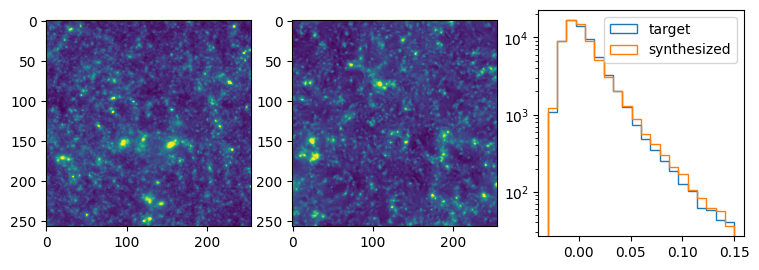

In [ ]:
# s_cov_iso P00 all
plt.figure(figsize=(9,3),dpi=100)
plt.subplot(131)
plt.imshow(image_target[0], vmin=-0.03, vmax=0.15 )
plt.subplot(132)
plt.imshow(image_syn[0], vmin=-0.03, vmax=0.15 )
plt.subplot(133)
plt.hist(image_target[0].flatten(),20,(-0.03,0.15),histtype='step',label='target')
plt.hist(image_syn[0].flatten(),20,(-0.03,0.15),histtype='step',label='synthesized')
plt.legend()
plt.yscale('log')
plt.show()

### synthesis results with different estimators

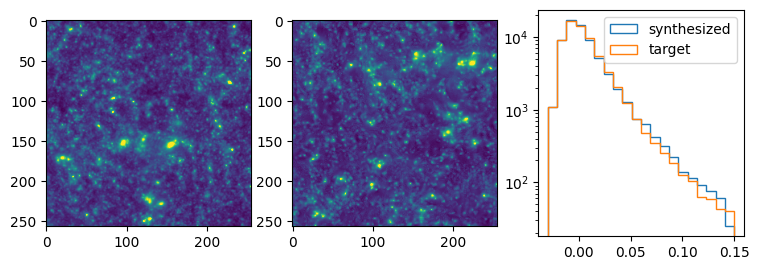

In [ ]:
# s_cov P00 all

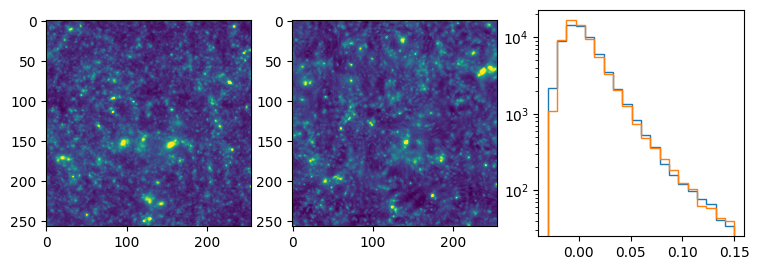

In [ ]:
# s_cov_iso P11 all

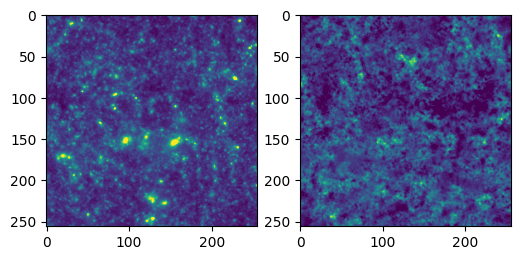

In [ ]:
# s_cov_iso shannon wavelet, J6 29s

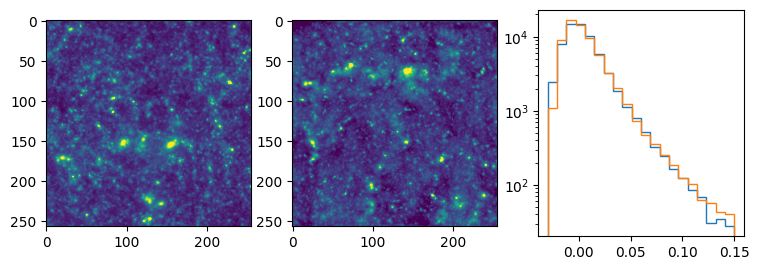

In [ ]:
# alpha_cov

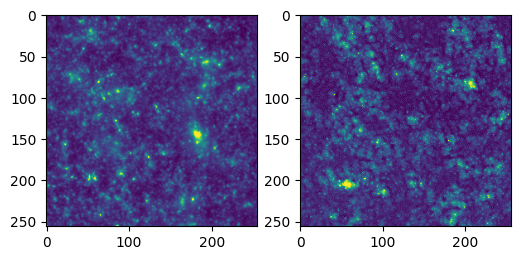

In [ ]:
# bi_linear

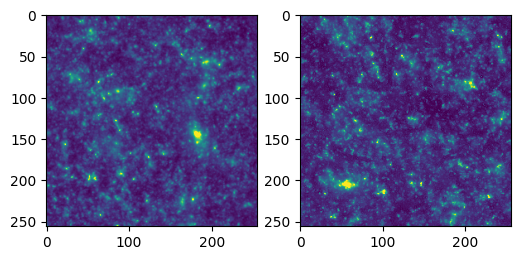

In [ ]:
# bi_log

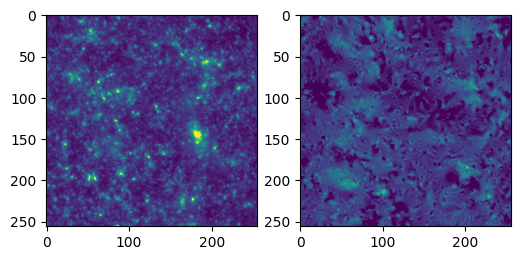

In [ ]:
# s_mean

## one field, estimator target

In [ ]:
normalization = 'P00'

# load two images
M = N = 256
image_target1 = scattering.standardize(np.log(np.load(colab_dir + 'H81_0_Quijote.npy')[None,:M,:N]+1))
image_target2 = scattering.standardize(np.load(colab_dir + 'H_51.npy').astype(np.float32)[:1,:M,:N])

# calculate scattering correlations for them
J = 7
L = 4
st_calc = scattering.Scattering2d(M, N, J, L, device='gpu')
s_cov1 = st_calc.scattering_cov(image_target1, flatten=True, normalization=normalization)['for_synthesis_iso']
s_cov2 = st_calc.scattering_cov(image_target2, flatten=True, normalization=normalization)['for_synthesis_iso']

In [ ]:
# linearly interpolate the coefficients between image1 and image2
r1 = 0.75
coef_target = r1*s_cov1 + (1-r1)*s_cov2
image_init = image_target1 + 0.0
for r1 in [0.5, 0.25, 0.]:
    coef_target = torch.cat((coef_target, r1*s_cov1 + (1-r1)*s_cov2), dim=0)
    image_init = np.concatenate((image_init, image_target1), axis=0)

# synthesize based on values of coefficients
# 's_mean', 's_mean_iso', 's_cov', 's_cov_iso', 'alpha_cov', 'bispectrum'
image_syn = scattering.synthesis(
    's_cov_iso', coef_target, mode='estimator',
    M=M, N=N, J=J, L=L, image_init=image_init,
    steps=200, learning_rate=0.2, device='gpu', seed=0,
    normalization=normalization,
    # print_each_step=True
)

/content/drive/MyDrive/Colab Notebooks/scattering/__init__.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if image_init=='random phase':


# of estimators:  2927
max residual:  1.2190745 , mean residual:  0.004900724
max residual:  0.008802033 , mean residual:  0.00015746769
time used:  40.28125739097595 s


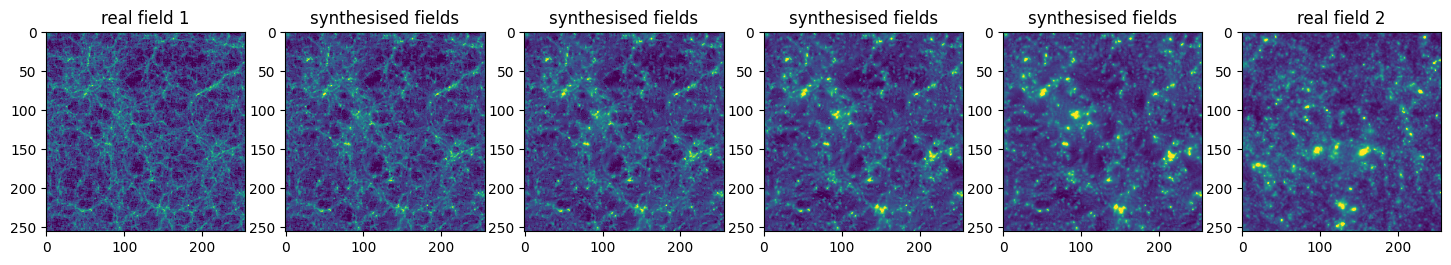

In [ ]:
# plot
plt.figure(figsize=((2+len(image_syn))*3,3),dpi=100)
plt.subplot(1,2+len(image_syn),1)
plt.imshow(image_target1[0], vmin=-1.5, vmax=5.15)#vmin=0, vmax=6
plt.title('real field 1')

for i in range(len(image_syn)):
    plt.subplot(1,2+len(image_syn),i+2)
    plt.imshow(image_syn[i], vmin=-1.5, vmax=5.15)#vmin=0, vmax=6
    plt.title('synthesised fields')

plt.subplot(1,2+len(image_syn),2+len(image_syn))
plt.imshow(image_target2[0], vmin=-1.5, vmax=5.15)#vmin=0, vmax=6
plt.title('real field 2')
plt.show()

### other synthesis result with manipulated estimators （not polished yet）

In [ ]:
# manipulating the value of coefficients 

# coef_target = s_cov_iso1['for_synthesis_iso'].cpu().numpy()*1.
# # coef_target[:,:J] += np.arange(J) * 0.25 # P0
# # coef_target[:,J:2*J] += np.arange(J) * 0.125 # S1
# # coef_target[:,2*J:2*J+J*(J+1)*L//2] -= 5 # P11
# # coef_target[:,2*J+J*(J+1)*L//2:2*J+J*(J+1)*L] -= 5 # C01_real
# # coef_target[:,2*J+J*(J+1)*L:2*J+J*(J+1)*L//2*3] = 0 # C01_imag
# coef_target[:,2*J+J*(J+1)*L//2*3:] *= 0.5 # C11


In [ ]:
ac_calc = scattering.PhaseHarmonics2d(M, N, J, L, device='gpu')
alpha_cov1 = ac_calc(image_target1)
alpha_cov2 = ac_calc(image_target2)

# alpha
# synthesize
# 's_mean', 's_mean_iso', 's_cov', 's_cov_iso', 'alpha_cov', 'bispectrum'

r1 = 0.75
coef_target = r1 * alpha_cov1 + (1-r1) * alpha_cov2
image_init = image_target1 + 0.0
for r1 in [0.5, 0.25, 0.]:
    coef_target = torch.cat(
        (coef_target, r1 * alpha_cov1 + (1-r1) * alpha_cov2), dim=0,
    )
    image_init = np.concatenate(
        (image_init, image_target1), axis=0
    )

image_syn = scattering.synthesis(
    'alpha_cov', coef_target, M=M, N=N, J=J, L=L, 
    mode='estimator', steps=600, learning_rate=0.5, device='gpu', seed=0,
    image_init=image_init)

number of moments (without low-pass and harr):  56640
this chunk 0  size is  960  among  960
# of estimators:  12534
max residual:  527.0197 , mean residual:  5.097191
max residual:  527.0197 , mean residual:  4.768888
time used:  42.67179751396179 s


In [ ]:
coef_target = s_cov_iso1['for_synthesis_iso'].cpu()*1.
# coef_target[:,:J] += np.arange(J) * 0 # P0
# coef_target[:,J:2*J] += np.arange(J) * 0 # S1
# coef_target[:,2*J:2*J+J*(J+1)*L//2] += 0 # P11
coef_target[:,2*J+J*(J+1)*L//2:2*J+J*(J+1)*L] = 1 # C01_real
# coef_target[:,2*J+J*(J+1)*L:2*J+J*(J+1)*L//2*3] = 0 # C01_imag
coef_target[:,2*J+J*(J+1)*L//2*3:] = 0.5 # C11

image_syn = scattering.synthesis(
    's_cov_iso', coef_target, M=M, N=N, J=J, L=L, 
    mode='estimator', steps=100, learning_rate=0.5, device='gpu', seed=0,
    image_init=image_init)

# of estimators:  4000
max residual:  2.6279192 , mean residual:  0.4320578
max residual:  0.88753897 , mean residual:  0.20153525
time used:  19.75050687789917 s


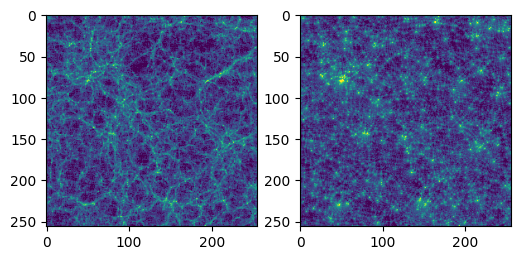

In [ ]:
plt.figure(figsize=(6,3),dpi=100)
plt.subplot(121)
plt.imshow((image_target1[0] - image_target1[0].mean())/ image_target1[0].std(), vmin=-1.5, vmax=5.15)#vmin=0, vmax=6
plt.subplot(122)
plt.imshow((image_syn[0] - image_syn[0].mean()) / image_syn[0].std(), vmin=-1.5, vmax=5.15)#vmin=0, vmax=6 
plt.show()

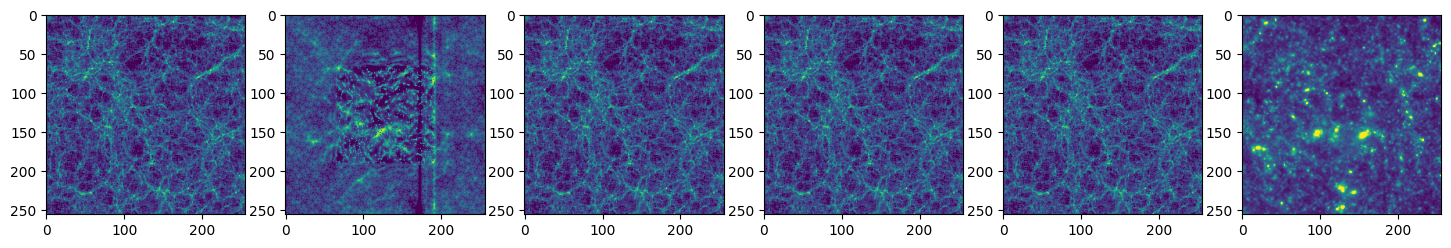

In [ ]:
# alpha
plt.figure(figsize=((2+len(image_syn))*3,3),dpi=100)
plt.subplot(1,2+len(image_syn),1)
plt.imshow((image_target1[0] - image_target1[0].mean())/ image_target1[0].std(), vmin=-1.5, vmax=5.15)#vmin=0, vmax=6
for i in range(len(image_syn)):
    plt.subplot(1,2+len(image_syn),i+2)
    plt.imshow((image_syn[i] - image_syn[i].mean()) / image_syn[i].std(), vmin=-1.5, vmax=5.15)#vmin=0, vmax=6
plt.subplot(1,2+len(image_syn),2+len(image_syn))
plt.imshow((image_target2[0] - image_target2[0].mean())/ image_target2[0].std(), vmin=-1.5, vmax=5.15)#vmin=0, vmax=6
plt.show()

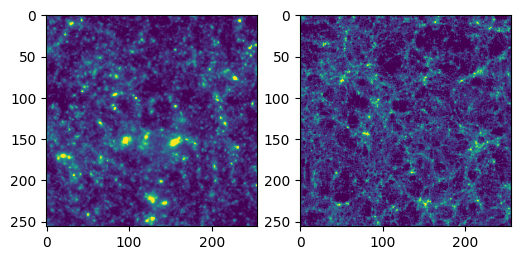

In [ ]:
plt.figure(figsize=(6,3),dpi=100)
plt.subplot(121)
plt.imshow((image_target2[0] - image_target2[0].mean())/ image_target2[0].std(), vmin=-1, vmax=5.15)#vmin=0, vmax=6
plt.subplot(122)
plt.imshow((image_syn[0] - image_syn[0].mean()) / image_syn[0].std(), vmin=-1, vmax=5.15)#vmin=0, vmax=6 
plt.show()

## two fields, image target

In [ ]:
# load image
image_target = np.load(colab_dir + 'turbulence/iso/iso_u_t1z1.npy')[None,:,:,1,0]
image_b = np.load(colab_dir + 'turbulence/iso/iso_p_t1z1.npy')[None,:,:,1,0]

# downsampling (make the images smaller)
for level in range(2):
    image_target = scattering.downsample(image_target)
    image_b      = scattering.downsample(image_b)

# synthesize
# 's_mean', 's_mean_iso', 's_cov', 's_cov_iso', 'alpha_cov', 'bispectrum'
image_syn = scattering.synthesis(
    's_cov_2fields_iso', target=image_target, mode='image', image_b=image_b, image_init='random phase',
    steps=800, learning_rate=0.5, device='gpu', seed=0,
    # normalization='P00',
    # print_each_step=True
)

input_size:  (1, 256, 256)
# of estimators:  10782
max residual:  0.28264487 , mean residual:  0.0020965736
max residual:  0.00022814795 , mean residual:  1.0290891e-05
time used:  301.36587929725647 s


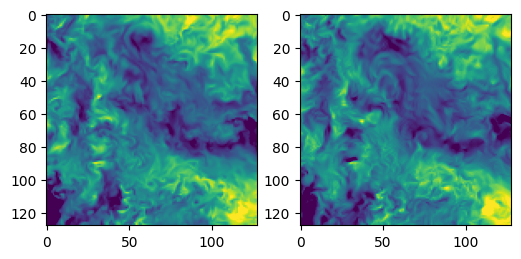

In [ ]:
# s_cov_iso, step=800, 301s, t1z1, P00, from GRF, 0.5
plt.figure(figsize=(6,3),dpi=100)
plt.subplot(121)
plt.imshow(image_target[0][:128,:128], vmin=-1, vmax=1)
plt.subplot(122)
plt.imshow(image_syn[0][:128,:128], vmin=-1, vmax=1)
plt.show()

### synthesis results with other settings

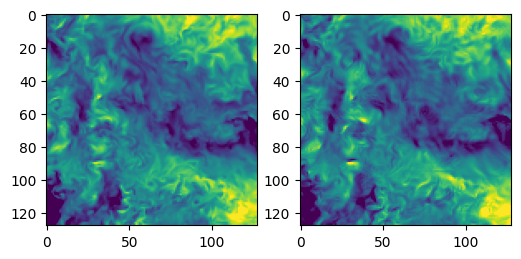

In [ ]:
# s_cov_iso, step=800, 255s, t1z1, old

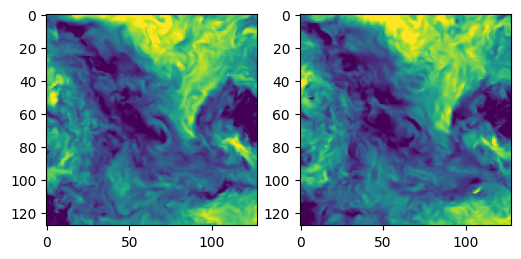

In [ ]:
# s_cov_iso, step=800, 308s, t501z1, P00, from GRF

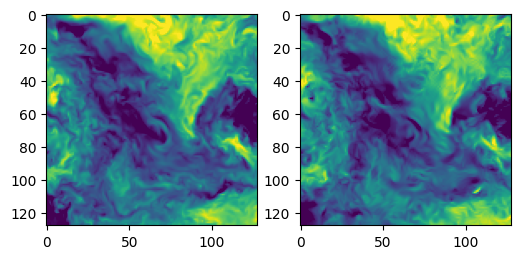

In [ ]:
# s_cov_iso, step=800, 317s, t501z1, P00, from GRF, 0.2

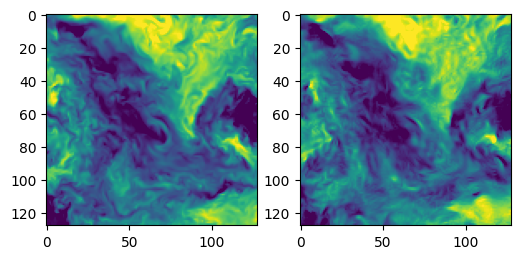

In [ ]:
# s_cov_iso, step=800, 306s, t501z1, P11, from GRF, 0.2

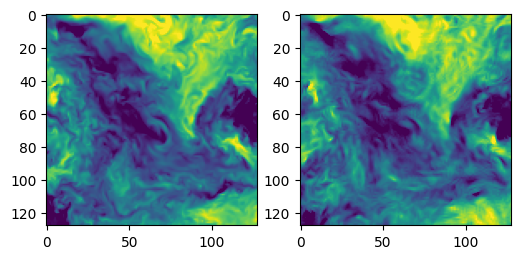

In [ ]:
# s_cov_iso, step=800, 300s, t501z1, P11, from GRF, 0.5

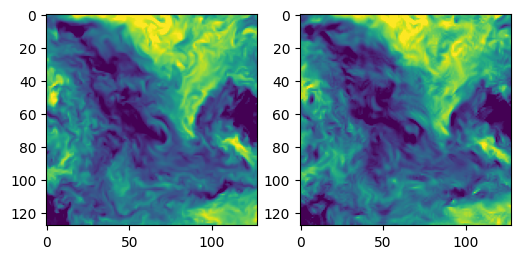

In [ ]:
# s_cov_iso, step=800, 255s, t501z1, P11, old
plt.figure(figsize=(6,3),dpi=100)
plt.subplot(121)
plt.imshow(image_target[0][:128,:128], vmin=-1, vmax=1)#vmin=0, vmax=6
plt.subplot(122)
plt.imshow(image_syn[0][:128,:128], vmin=-1, vmax=1)#vmin=0, vmax=6
plt.show()

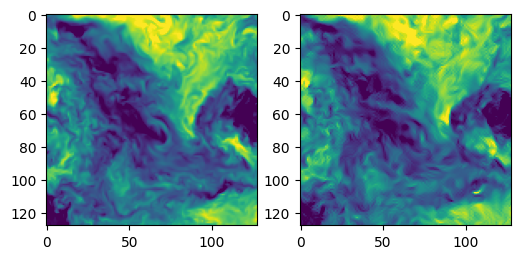

In [ ]:
# s_cov_iso, step=800, 308s, t501z1, P00, from WN, 0.5

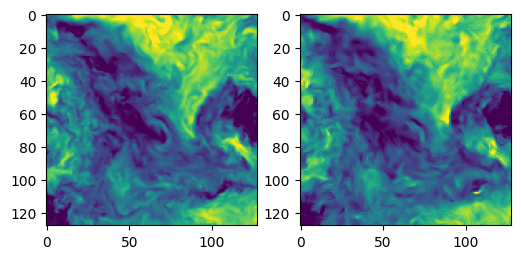

In [ ]:
# s_cov_iso, step=800, 299s, t501z1, P00, from WN, 0.2

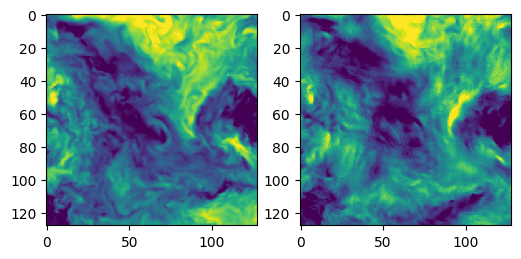

In [ ]:
# s_cov_iso, step=800, 300s, t501z1, P11, from WN, 0.2

### for comparison: single field synthesis

input_size:  (1, 256, 256)
# of estimators:  2927
max residual:  0.1281147 , mean residual:  0.0022877108
max residual:  0.0083618425 , mean residual:  0.00018715639
time used:  32.614519119262695 s


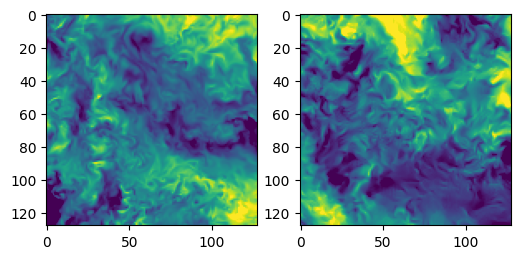

In [ ]:
# load image
image_target = np.load(colab_dir + 'turbulence/iso/iso_u_t1z1.npy')[None,:,:,1,0]
image_b = np.load(colab_dir + 'turbulence/iso/iso_p_t1z1.npy')[None,:,:,1,0]

# downsampling (make the images smaller)
for level in range(2):
    image_target = scattering.downsample(image_target)
    image_b      = scattering.downsample(image_b)

# s_cov_iso single field
image_syn = scattering.synthesis(
    's_cov_iso', target=image_target, mode='image', image_init='random phase',
    steps=200, learning_rate=0.5,device='gpu', seed=0,
)

plt.figure(figsize=(6,3),dpi=100)
plt.subplot(121)
plt.imshow(image_target[0][:128,:128], vmin=-1, vmax=1)
plt.subplot(122)
plt.imshow(image_syn[0][:128,:128], vmin=-1, vmax=1)
plt.show()